**Lab 10 – Data cleaning and feature engineering**

_This notebook contains the sample from https://www.kaggle.com/learn/feature-engineering, https://www.kaggle.com/learn/data-cleaning_, https://madewithml.com/courses/mlops/preprocessing/, https://github.com/microsoft/Data-Science-For-Beginners/blob/main/2-Working-With-Data/08-data-preparation/README.md, https://scikit-learn.org/stable/modules/preprocessing.html# and https://www.books.com.tw/products/0010883417 

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/10_Clean_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/10_Clean_feature_engineering.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
!pip install fancyimpute -q
!pip install thefuzz -q
!pip install --upgrade xlrd -q
!pip install category_encoders -q

     |████████████████████████████████| 154 kB 8.0 MB/s 
     |████████████████████████████████| 96 kB 2.6 MB/s 
     |████████████████████████████████| 86 kB 2.9 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GroupKFold, train_test_split

from fancyimpute import SoftImpute

# helpful character encoding module
import chardet
from thefuzz import fuzz
from thefuzz import process

from category_encoders import MEstimateEncoder
from category_encoders.wrapper import NestedCVWrapper

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

## Handling missing value

In this course, you'll learn why you've run into the data cleaning problems and, more importantly, how to fix them! In this section, you’ll learn how to tackle some of the most common data cleaning problems so you can get to actually analyzing your data faster. 

### Take a first look at the data

For demonstration, we'll use a dataset of events that occured in American Football games. You'll apply your new skills to a dataset of building permits issued in San Francisco.

In [4]:
# Upload the API’s key JSON file to your Colab
# session by running the following code in a notebook cell:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phonchi","key":"543eb33eabf413fb77a6b374f96ccfca"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
!kaggle datasets download -d maxhorowitz/nflplaybyplay2009to2016

 94% 258M/274M [00:01<00:00, 151MB/s]
100% 274M/274M [00:01<00:00, 145MB/s]


In [11]:
!unzip -qq nflplaybyplay2009to2016

In [12]:
# read in all our data
nfl_data = pd.read_csv("NFL Play by Play 2009-2017 (v4).csv")

# set seed for reproducibility
np.random.seed(0) 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (25,51) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The first thing to do when you get a new dataset is take a look at some of it. This lets you see that it all read in correctly and gives an idea of what's going on with the data. In this case, let's see if there are any missing values, which will be reprsented with `NaN` or `None`.

In [13]:
# look at the first five rows of the nfl_data file. 
# I can see a handful of missing data already!
nfl_data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


In [14]:
nfl_data.shape

(407688, 102)

### How many missing data points do we have?

Ok, now we know that we do have some missing values. Let's see how many we have in each column. 

In [15]:
# get the number of missing data points per column
missing_values_count = nfl_data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

In [16]:
# how many total missing values do we have?
total_cells = np.product(nfl_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

24.87214126835169


Almost a quarter of the cells in this dataset are empty! In the next step, we're going to take a closer look at some of the columns with missing values and try to figure out what might be going on with them.

Looking at the number of missing values in the `nfl_data` dataframe, we notice that the column "TimesSec" has a lot of missing values in it. By looking at [the documentation](https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016), we can see that this column has information on the number of seconds left in the game when the play was made. This means that these values are probably missing because **they were not recorded**, rather than because they don't exist. So, it would make sense for us to try and guess what they should be rather than just leaving them as NA's.

On the other hand, there are other fields, like "PenalizedTeam" that also have lot of missing fields. In this case, though, the field is missing because if there was no penalty then it doesn't make sense to say *which* team was penalized. For this column, it would make more sense to either leave it empty or to add a third value like "neither" and use that to replace the NA's.

We'll cover some "quick and dirty" techniques that can help you with missing values but will probably also end up removing some useful information or adding some noise to your data.

### Drop missing values

If you're sure you want to drop rows with missing values, pandas does have a handy function, `dropna()` to help you do this. Let's try it out on our NFL dataset!

In [17]:
# remove all the rows that contain a missing value
# This is because every row in our dataset had at least one missing value. 
# We might have better luck removing all the *columns* that have at least one missing value instead.
nfl_data.dropna()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season


In [18]:
# remove all columns with at least one missing value
columns_with_na_dropped = nfl_data.dropna(axis=1)
columns_with_na_dropped.head()

,Date,GameID,Drive,qtr,TimeUnder,ydstogo,ydsnet,PlayAttempted,Yards.Gained,sp,...,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,ExPoint_Prob,TwoPoint_Prob,Season
0,2009-09-10,2009091000,1,1,15,0,0,1,39,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
1,2009-09-10,2009091000,1,1,15,10,5,1,5,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
2,2009-09-10,2009091000,1,1,15,5,2,1,-3,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
3,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
4,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,0,None,3,3,3,3,3,0.0,0.0,2009


In [19]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % nfl_data.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 102 

Columns with na's dropped: 41


Notice that this can drop a lot of data that you might want to keep, particularly in smaller datasets. What if you just want to drop rows or columns that contain several or even just all null values? You specify those setting in dropna with the `how` and `thresh` parameters.

By default, `how='any'`. You could alternatively specify `how='all'` so as to **drop only rows or columns that contain all null values**. The `thresh `parameter gives you finer-grained control: you set the number of non-null values that a row or column needs to have in order to be kept.

In [36]:
df1 = pd.DataFrame([[ 1, np.nan, 7], 
              [ 2,  5,  8], 
              [ np.nan, 6, 9]])
df1[3] = np.nan
df1

,0,1,2,3
0,1.0,NaN,7,NaN
1,2.0,5.0,8,NaN
2,NaN,6.0,9,NaN


In [37]:
df1.dropna(thresh=3)

,0,1,2,3
1,2.0,5.0,8,NaN


Here, the first and last row have been dropped, because they contain only two non-null values.

### Filling in missing values automatically

Depending on your dataset, it can sometimes make more sense to fill null values with valid ones rather than drop them. Pandas provides `fillna`, which returns a copy of the `Series` or `DataFrame` with the missing values replaced with one of your choosing. Let's create another example `Series` to see how this works in practice.

In [38]:
# You can fill all of the null entries with a single value, such as 0:
df1.fillna(0)

,0,1,2,3
0,1.0,0.0,7,0.0
1,2.0,5.0,8,0.0
2,0.0,6.0,9,0.0


We could also replace missing values with whatever value comes directly after/before it in the same column. (This makes a lot of sense for datasets where the observations have some sort of logical order to them.)

You can forward-fill null values, which is to use the last valid value to fill a null:

In [39]:
df1.fillna(method='ffill', axis=0)

,0,1,2,3
0,1.0,NaN,7,NaN
1,2.0,5.0,8,NaN
2,2.0,6.0,9,NaN


Back-fill to propagate the next valid value backward to fill a null:

In [40]:
df1.fillna(method='bfill', axis=0)

,0,1,2,3
0,1.0,5.0,7,NaN
1,2.0,5.0,8,NaN
2,NaN,6.0,9,NaN


Notice that when a previous value is not available for forward-filling, the null value remains.

### Imputation of missing value

#### Univariate feature imputation

The `SimpleImputer` class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.

In [43]:
df2 = pd.DataFrame([[1, 2], [np.nan, 3], [7, 6]])
df2

,0,1
0,1.0,2
1,NaN,3
2,7.0,6


The following snippet demonstrates how to replace missing values, encoded as `np.nan`, using the mean value of the columns (axis 0) that contain the missing values:

In [44]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit_transform(df2)

array([[1., 2.],
       [4., 3.],
       [7., 6.]])

The `SimpleImputer` class also supports categorical data represented as string values or pandas categoricals when using the 'most_frequent' or 'constant' strategy:

In [45]:
df2 = pd.DataFrame([["a", "x"],
           [np.nan, "y"],
           ["a", np.nan],
          ["b", "y"]], dtype="category")
df2

,0,1
0,a,x
1,NaN,y
2,a,NaN
3,b,y


In [46]:
imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df2))

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


#### Multivariate feature imputation

A more sophisticated approach is to use the `IterativeImputer` class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. 

In [47]:
imp = IterativeImputer(max_iter=10, random_state=0)
# the model learns that the second feature is double the first
imp.fit_transform([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

array([[ 1.        ,  2.        ],
       [ 3.        ,  6.        ],
       [ 4.        ,  8.        ],
       [ 1.50004509,  3.        ],
       [ 7.        , 14.00004135]])

In [49]:
 # You can also use other regressor as well (default is regularized linear regression)
 est = ExtraTreesRegressor(n_estimators=10, random_state=0)
 imp = IterativeImputer(random_state=0, estimator=est)
 imp.fit_transform([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

array([[1. , 2. ],
       [3. , 6. ],
       [4. , 8. ],
       [1.6, 3. ],
       [7. , 8. ]])

`IterativeImputer` can also be used for multiple imputations by applying it repeatedly to the same dataset with different random seeds when `sample_posterior=True`

The `KNNImputer` class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, `nan_euclidean_distances`, is used to find the nearest neighbors. Each missing feature is imputed using values from `n_neighbors` nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. **If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed.** 

The following snippet demonstrates how to replace missing values, encoded as `np.nan`, using the mean feature value of the two nearest neighbors of samples with missing values:

In [51]:
X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

if you wishes to apply matrix completion to your data

In [56]:
SoftImpute().fit_transform(X)

[SoftImpute] Max Singular Value of X_init = 16.044670
[SoftImpute] Iter 1: observed MAE=0.129498 rank=3
[SoftImpute] Iter 2: observed MAE=0.129346 rank=3
[SoftImpute] Iter 3: observed MAE=0.129795 rank=3
[SoftImpute] Iter 4: observed MAE=0.131896 rank=3
[SoftImpute] Iter 5: observed MAE=0.134509 rank=3
[SoftImpute] Iter 6: observed MAE=0.137663 rank=3
[SoftImpute] Iter 7: observed MAE=0.141068 rank=3
[SoftImpute] Iter 8: observed MAE=0.143794 rank=3
[SoftImpute] Iter 9: observed MAE=0.145304 rank=3
[SoftImpute] Iter 10: observed MAE=0.145850 rank=3
[SoftImpute] Iter 11: observed MAE=0.145866 rank=3
[SoftImpute] Iter 12: observed MAE=0.145914 rank=3
[SoftImpute] Iter 13: observed MAE=0.146068 rank=3
[SoftImpute] Iter 14: observed MAE=0.146126 rank=2
[SoftImpute] Iter 15: observed MAE=0.146125 rank=2
[SoftImpute] Iter 16: observed MAE=0.146132 rank=2
[SoftImpute] Iter 17: observed MAE=0.146126 rank=2
[SoftImpute] Iter 18: observed MAE=0.146092 rank=2
[SoftImpute] Iter 19: observed MAE=0.

array([[1.        , 2.        , 1.29115131],
       [3.        , 4.        , 3.        ],
       [5.10495139, 6.        , 5.        ],
       [8.        , 8.        , 7.        ]])

For more information, please refer to https://github.com/iskandr/fancyimpute or https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute, which provides a very efficient implementation for imputing your data.

## Other data cleaning problem

### Duplicate data entry

In addition to missing data, you will often encounter duplicated data in real-world datasets. Fortunately, pandas provides an easy means of detecting and removing duplicate entries.

You can easily spot duplicate values using the `duplicated` method in pandas, which returns a Boolean mask indicating whether an entry in a DataFrame is a duplicate of an earlier one. Let's create another example DataFrame to see this in action.

In [24]:
df3 = pd.DataFrame({'letters': ['A','B'] * 2 + ['B'],
                         'numbers': [1, 2, 1, 3, 3]})
df3

,letters,numbers
0,A,1
1,B,2
2,A,1
3,B,3
4,B,3


In [25]:
df3.duplicated()

0    False
1    False
2     True
3    False
4     True
dtype: bool

`drop_duplicates` will simply returns a copy of the data for which all of the duplicated values are False:

In [26]:
df3.drop_duplicates()

,letters,numbers
0,A,1
1,B,2
3,B,3


Both `duplicated` and `drop_duplicates` default to consider all columns but you can specify that they examine only a subset of columns in your DataFrame:

In [27]:
df3.drop_duplicates(['letters'])

,letters,numbers
0,A,1
1,B,2


### Inconsistent data entry

In [ ]:
!kaggle datasets download -d alexisbcook/pakistan-intellectual-capital
!unzip -qq pakistan-intellectual-capital.zip

pakistan-intellectual-capital.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# read in all our data
professors = pd.read_csv("pakistan_intellectual_capital.csv")

In [ ]:
professors.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


Say we're interested in cleaning up the "Country" column to make sure there's no data entry inconsistencies in it. We could go through and check each row by hand, of course, and hand-correct inconsistencies when we find them. There's a more efficient way to do this, though!

In [ ]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array([' Germany', ' New Zealand', ' Sweden', ' USA', 'Australia',
       'Austria', 'Canada', 'China', 'Finland', 'France', 'Greece',
       'HongKong', 'Ireland', 'Italy', 'Japan', 'Macau', 'Malaysia',
       'Mauritius', 'Netherland', 'New Zealand', 'Norway', 'Pakistan',
       'Portugal', 'Russian Federation', 'Saudi Arabia', 'Scotland',
       'Singapore', 'South Korea', 'SouthKorea', 'Spain', 'Sweden',
       'Thailand', 'Turkey', 'UK', 'USA', 'USofA', 'Urbana', 'germany'],
      dtype=object)

Just looking at this, we can see some problems due to inconsistent data entry: ' Germany', and 'germany', for example, or ' New Zealand' and 'New Zealand'.

The first thing we are going to do is make everything lower case (we can change it back at the end if we like) and remove any white spaces at the beginning and end of cells. **Inconsistencies in capitalizations and trailing white spaces are very common in text data and you can fix a good 80% of your text data entry inconsistencies by doing this.**

In [ ]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()
# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

#### Use fuzzy matching to correct inconsistent data entry

Alright, let's take another look at the 'Country' column and see if there's any more data cleaning we need to do

In [ ]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea',
       'southkorea', 'spain', 'sweden', 'thailand', 'turkey', 'uk',
       'urbana', 'usa', 'usofa'], dtype=object)

It does look like there is another inconsistency: 'southkorea' and 'south korea' should be the same. We're going to use the fuzzywuzzy package to help identify which strings are closest to each other. This dataset is small enough that we could probably correct errors by hand, but that approach doesn't scale well. (Would you want to correct a thousand errors by hand? What about ten thousand? Automating things as early as possible is generally a good idea!)

thefuzz returns a ratio given two strings. The closer the ratio is to 100, the smaller the edit distance between the two strings. Here, we're going to get the ten strings from our list of cities that have the closest distance to ""south korea"

In [ ]:
# get the top 10 closest matches to "south korea"
matches = process.extract("south korea", countries, limit=10, scorer=fuzz.token_sort_ratio)

# take a look at them
matches

[('south korea', 100),
 ('southkorea', 48),
 ('saudi arabia', 43),
 ('norway', 35),
 ('ireland', 33),
 ('portugal', 32),
 ('singapore', 30),
 ('netherland', 29),
 ('macau', 25),
 ('usofa', 25)]

We can see that two of the items in the cities are very close to "south korea": "south korea" and "southkorea". Let's replace all rows in our "Country" column that have a ratio of > 47 with "south korea".

To do this, we are going to write a function.

In [ ]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = process.extract(string_to_match, strings, limit=10, scorer=fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

Now that we have a function, we can put it to the test!

In [ ]:
# use the function we just wrote to replace close matches to "south korea" with "south korea"
replace_matches_in_column(df=professors, column='Country', string_to_match="south korea")

All done!


And now let's check the unique values in our "Country" column again and make sure we've tidied up "south korea" correctly.

In [ ]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa', 'usofa'],
      dtype=object)

Now we only have "south korea" in our dataframe and we didn't have to change anything by hand.

### Character encoding

It was pretty hard to deal with encodings in Python 2, but thankfully in Python 3 it's a lot simpler. There are two main data types you'll encounter when working with text in Python 3. One is is the string, which is what text is by default.

In [ ]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

The other data is the [bytes](https://docs.python.org/3.1/library/functions.html#bytes) data type, which is a sequence of integers. You can convert a string into bytes by specifying which encoding it's in:

In [ ]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors="replace")

# check the type
type(after)

bytes

If you look at a bytes object, you'll see that it has a b in front of it, and then maybe some text after. **That's because bytes are printed out as if they were characters encoded in ASCII**. (ASCII is an older character encoding that doesn't really work for writing any language other than English.) Here you can see that our euro symbol  has been replaced with some mojibake that looks like "\xe2\x82\xac" when it's printed as if it were an ASCII string

In [ ]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

When we convert our bytes back to a string with the correct encoding, we can see that our text is all there correctly, which is great! :)

In [ ]:
# convert it back to utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


However, when we try to use a different encoding to map our bytes into a string, we get an error. This is because the encoding we're trying to use doesn't know what to do with the bytes we're trying to pass it. You need to tell Python the encoding that the byte string is actually supposed to be in

In [ ]:
# try to decode our bytes with the ascii encoding
print(after.decode("ascii"))

UnicodeDecodeError: ignored

We can also run into trouble if we try to use the wrong encoding to map from a string to bytes. Like we said earlier, strings are UTF-8 by default in Python 3, so if we try to treat them like they were in another encoding we'll create problems. 

For example, if we try to convert a string to bytes for ASCII using `encode()`, we can ask for the bytes to be what they would be if the text was in ASCII. Since our text isn't in ASCII, though, there will be some characters it can't handle. We can automatically replace the characters that ASCII can't handle. If we do that, however, **any characters not in ASCII will just be replaced with the unknown character.** Then, when we convert the bytes back to a string, the character will be replaced with the unknown character. The dangerous part about this is that there's not way to tell which character it *should* have been. That means we may have just made our data unusable!

In [ ]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

This is the euro symbol: ?


The best time to convert non UTF-8 input into UTF-8  is when you read in files, which we'll talk about next.

### Reading in files with encoding problems

Most files you'll encounter will probably be encoded with UTF-8. This is what Python expects by default, so most of the time you won't run into problems. However, sometimes you'll get an error like this:

In [ ]:
!kaggle datasets download -d kemical/kickstarter-projects
!unzip -qq kickstarter-projects.zip

kickstarter-projects.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# try to read in a file not in UTF-8
kickstarter_2016 = pd.read_csv("ks-projects-201612.csv")

UnicodeDecodeError: ignored

Notice that we get the same `UnicodeDecodeError` we got when we tried to decode UTF-8 bytes as if they were ASCII! **This tells us that this file isn't actually UTF-8**. We don't know what encoding it actually *is* though. One way to figure it out is to try and test a bunch of different character encodings and see if any of them work. A better way, though, is to use the chardet module to try and automatically guess what the right encoding is. It's not 100% guaranteed to be right, but it's usually faster than just trying to guess.

We are going to just look at the first ten thousand bytes of this file. This is usually enough for a good guess about what the encoding is and is much faster than trying to look at the whole file. (Especially with a  large file this can be very slow.)

In [ ]:
# look at the first ten thousand bytes to guess the character encoding
with open("ks-projects-201612.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


So chardet is 73%  confidence that the right encoding is "Windows-1252". Let's see if that's correct:

In [ ]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv("ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


Yep, looks like chardet was right! The file reads in with no problem (although we do get a warning about datatypes) and when we look at the first few rows it seems to be fine. 

What if the encoding chardet guesses isn't right? Since chardet is basically just a fancy guesser, sometimes it will guess the wrong encoding. **One thing you can try is looking at more or less of the file and seeing if you get a different result and then try that.**

### Saving your files with UTF-8 encoding


Finally, once you've gone through all the trouble of getting your file into UTF-8, you'll probably want to keep it that way. The easiest way to do that is to save your files with UTF-8 encoding. The good news is, since UTF-8 is the standard encoding in Python, when you save a file it will be saved as UTF-8 by default:

In [ ]:
# save our file (will be saved as UTF-8 by default!)
kickstarter_2016.to_csv("ks-projects-201612-utf8.csv")

## Scaling and normalization

### Standardization

By scaling your variables, you can help compare different variables on equal footing. The preprocessing module provides the `StandardScaler` utility class, which is a quick and easy way to perform the following operation on an array-like dataset.

In [67]:
train = pd.read_csv('train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('test_preprocessed.csv')
train_x_saved = train_x.copy()
test_x_saved = test_x.copy()

def load_data():
    train_x, test_x = train_x_saved.copy(), test_x_saved.copy()
    return train_x, test_x

train

,age,sex,height,weight,product,amount,medical_info_a1,medical_info_a2,medical_info_a3,medical_info_b1,...,medical_keyword_6,medical_keyword_7,medical_keyword_8,medical_keyword_9,medical_keyword_10,year,month,day,yearmonth,target
0,50,1,166.445608,65.016732,9,7000000,134,202,1,11,...,1,0,1,0,0,2015,2,3,24182,0
1,68,0,164.334615,56.544217,0,7000000,438,263,3,14,...,0,1,1,0,0,2015,5,9,24185,0
2,77,1,167.462917,54.242267,2,6000000,313,325,1,18,...,1,0,1,0,0,2016,2,13,24194,1
3,17,1,177.097725,71.147762,3,8000000,342,213,2,11,...,0,0,1,0,0,2015,7,6,24187,0
4,62,0,158.165788,65.240697,1,9000000,327,102,0,14,...,0,1,1,1,0,2016,9,17,24201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,1,182.729800,73.393777,1,2000000,189,232,7,17,...,0,0,1,1,0,2015,10,21,24190,0
9996,33,0,167.701136,75.006529,8,9000,426,202,3,19,...,0,0,1,1,0,2015,5,28,24185,0
9997,44,0,145.609998,47.739397,8,1000,370,274,1,11,...,0,0,1,0,1,2016,2,29,24194,0
9998,34,0,165.796017,57.567695,6,5000,291,105,1,13,...,1,1,1,1,0,2016,2,27,24194,0


In [61]:
num_cols = ['age', 'height', 'weight', 'amount',
            'medical_info_a1', 'medical_info_a2', 'medical_info_a3', 'medical_info_b1']

In [69]:
train_x, test_x = load_data()
scaler = StandardScaler()
scaler.fit(train_x[num_cols])

StandardScaler()

Notice that **you should apply the same transfrom** on both training and testing dataset.

In [70]:
train_x[num_cols] = scaler.transform(train_x[num_cols])
test_x[num_cols] = scaler.transform(test_x[num_cols])

In [71]:
scaler.mean_,  scaler.scale_

(array([4.20265000e+01, 1.65892951e+02, 6.08570495e+01, 3.84084370e+06,
        2.99101200e+02, 2.49454700e+02, 1.98780000e+00, 1.44192000e+01]),
 array([2.16749209e+01, 9.40817216e+00, 1.07177883e+01, 3.45926743e+06,
        1.04491031e+02, 1.03710381e+02, 1.41733947e+00, 2.87131875e+00]))

Scaled data has zero mean and unit variance:

In [72]:
train_x[num_cols].mean(axis=0)

age                6.221690e-17
height            -2.822720e-15
weight            -1.951661e-16
amount            -2.140954e-16
medical_info_a1   -4.767020e-17
medical_info_a2   -3.677059e-17
medical_info_a3    1.968870e-16
medical_info_b1    2.520206e-16
dtype: float64

In [73]:
train_x[num_cols].std(axis=0)

age                1.00005
height             1.00005
weight             1.00005
amount             1.00005
medical_info_a1    1.00005
medical_info_a2    1.00005
medical_info_a3    1.00005
medical_info_b1    1.00005
dtype: float64

Note that it is possible to disable either centering or scaling by either passing `with_mean=False` or `with_std=False` to the constructor of `StandardScaler`.

### Scaling

An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one.

In [74]:
scaler = MinMaxScaler()
scaler.fit(train_x[num_cols])

MinMaxScaler()

In [75]:
train_x[num_cols] = scaler.transform(train_x[num_cols])
test_x[num_cols] = scaler.transform(test_x[num_cols])

Note that you can scale to any range by specifying `feature_range=(min, max)`.

### Logarithm transform and binning

In [76]:
x = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])

In [77]:
np.log(x)

array([0.        , 2.30258509, 4.60517019, 6.90775528, 9.21034037])

In [79]:
# If your data contains zero value, try to plus one first
np.log1p(x)

array([0.69314718, 2.39789527, 4.61512052, 6.90875478, 9.21044037])

Binning allows you to transform numerical variable to categorical variable

In [ ]:
x = [1, 7, 5, 4, 6, 3]

In [120]:
bin_edges = [-float('inf'), 3.0, 5.0, float('inf')]
binned = pd.cut(x, bin_edges, labels=False)
print(binned)

[0 2 2 2 2]


### Power transfrom

In [94]:
train_x, test_x = load_data()

Box-cox transform only works for postive data

In [95]:
pos_cols = [c for c in num_cols if (train_x[c] > 0.0).all() and (test_x[c] > 0.0).all()]

In [96]:
pt = PowerTransformer(method='box-cox')
pt.fit(train_x[pos_cols])

PowerTransformer(method='box-cox')

In [97]:
train_x[pos_cols] = pt.transform(train_x[pos_cols])
test_x[pos_cols] = pt.transform(test_x[pos_cols])

In [98]:
train_x, test_x = load_data()

In [99]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(train_x[num_cols])

PowerTransformer()

In [100]:
train_x[num_cols] = pt.transform(train_x[num_cols])
test_x[num_cols] = pt.transform(test_x[num_cols])

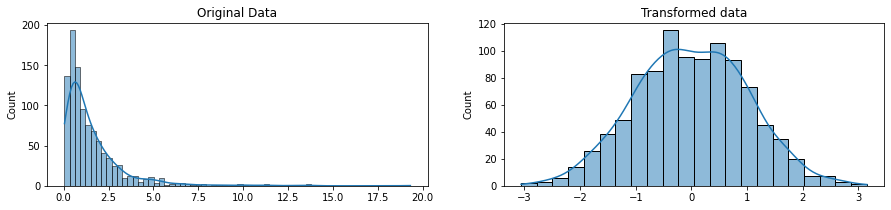

In [116]:
rng = np.random.RandomState(304)
original_data = rng.lognormal(size=(1000,1))
pt = PowerTransformer(method='box-cox')
transformed_data = pt.fit_transform(original_data)

fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(transformed_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

### Quantile transfrom

In [92]:
transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
transformer.fit(train_x[num_cols])

QuantileTransformer(n_quantiles=100, output_distribution='normal',
                    random_state=0)

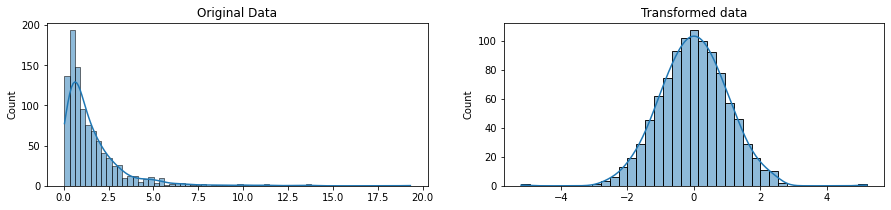

In [119]:
rng = np.random.RandomState(304)
original_data = rng.lognormal(size=(1000,1))
transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
transformed_data = transformer.fit_transform(original_data)

fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(transformed_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

## Feature Engineering

We'll see how adding a few synthetic features to a dataset can improve the predictive performance of a random forest model.

The [*Concrete*](https://www.kaggle.com/sinamhd9/concrete-comprehensive-strength) dataset contains a variety of concrete formulations and the resulting product's *compressive strength*, which is a measure of how much load that kind of concrete can bear. The task for this dataset is to predict a concrete's compressive strength given its formulation.

In [7]:
!kaggle datasets download -d sinamhd9/concrete-comprehensive-strength
!unzip -qq concrete-comprehensive-strength.zip

  0% 0.00/32.9k [00:00<?, ?B/s]
100% 32.9k/32.9k [00:00<00:00, 14.5MB/s]


In [2]:
df = pd.read_excel("Concrete_Data.xls")
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them.

We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [8]:
df.columns

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')

In [10]:
X = df.copy()
y = X.pop(df.columns[-1])

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.397


If you ever cook at home, you might know that the *ratio* of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of `CompressiveStrength`. The cell below adds three new ratio features to the dataset.

In [9]:
X = df.copy()
y = X.pop(df.columns[-1])

# Create synthetic features
X["FCRatio"] = X[df.columns[-2]] / X[df.columns[-3]]
X["AggCmtRatio"] = (X[df.columns[-3]] + X[df.columns[-2]]) / X[df.columns[0]]
X["WtrCmtRatio"] = X[df.columns[3]] / X[df.columns[0]]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.732


And sure enough, performance improved! This is evidence that these new ratio features exposed important information to the model that it wasn't detecting before.

### Mathematical Transforms

We'll use four datasets that having a range of feature types: [*US Traffic Accidents*](https://www.kaggle.com/sobhanmoosavi/us-accidents), [*1985 Automobiles*](https://www.kaggle.com/toramky/automobile-dataset), [*Concrete Formulations*](https://www.kaggle.com/sinamhd9/concrete-comprehensive-strength), and [*Customer Lifetime Value*](https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data). The following hidden cell loads them up.

In [6]:
!kaggle datasets download -d sobhanmoosavi/us-accidents
!kaggle datasets download -d toramky/automobile-dataset
!kaggle datasets download -d pankajjsh06/ibm-watson-marketing-customer-value-data

 96% 257M/269M [00:10<00:00, 23.8MB/s]
100% 269M/269M [00:10<00:00, 27.4MB/s]
  0% 0.00/4.87k [00:00<?, ?B/s]
100% 4.87k/4.87k [00:00<00:00, 2.38MB/s]
  0% 0.00/345k [00:00<?, ?B/s]
100% 345k/345k [00:00<00:00, 67.1MB/s]


In [8]:
!unzip -qq us-accidents.zip
!unzip -qq automobile-dataset.zip
!unzip -qq ibm-watson-marketing-customer-value-data.zip

In [9]:
accidents = pd.read_csv("US_Accidents_Dec21_updated.csv")
autos = pd.read_csv("Automobile_data.csv")
concrete = pd.read_excel("Concrete_Data.xls")
customer = pd.read_csv("WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In the *Automobile* dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [30]:
autos.replace("?", np.nan, inplace = True)
avg_bore=autos['bore'].astype('float').mean(axis=0)
autos["bore"].replace(np.nan, avg_bore, inplace=True)
avg_stroke = autos["stroke"].astype("float").mean(axis=0)
autos["stroke"].replace(np.nan, avg_stroke, inplace=True)

In [39]:
autos[["bore", "stroke"]] = autos[["bore", "stroke"]].astype("float")
autos["stroke_ratio"] = autos.stroke/ autos.bore
autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of `WindSpeed` in *US Accidents* is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

In [43]:
accidents.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

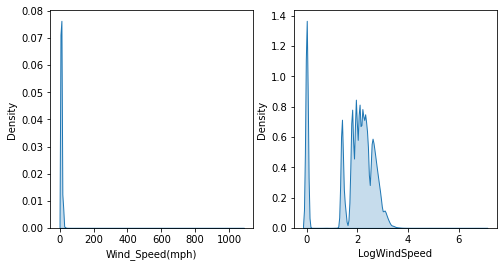

In [45]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents["Wind_Speed(mph)"].apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents["Wind_Speed(mph)"], shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

### Counts

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a **count**. These features will be *binary* (`1` for Present, `0` for Absent) or *boolean* (`True` or `False`). In Python, booleans can be added up just as if they were integers.

In *Traffic Accidents* are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the `sum` method:

In [54]:
roadway_features = ["Amenity", "Bump", "Crossing", "Give_Way",
    "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop",
    "Traffic_Calming", "Traffic_Signal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(20)

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,True,False,False,False,False,False,False,False,1
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,False,False,False,False,False,False,False,True,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,False,False,True,False,False,False,False,False,False,False,1
8,False,False,False,False,False,False,False,False,False,False,False,False,0
9,False,False,False,False,False,False,False,False,False,False,False,False,0


### Group Transforms

Finally we have **Group transforms**, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that categry could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose `State` for the grouping feature, `mean` for the aggregation function, and `Income` for the aggregated feature. To compute this in Pandas, we use the `groupby` and `transform` methods:

In [49]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


The `mean` function is a built-in dataframe method, which means we can pass it as a string to `transform`. Other handy methods include `max`, `min`, `median`, `var`, `std`, and `count`. Here's how you could calculate the frequency with which each state occurs in the dataset:


In [50]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


You could use a transform like this to create a "frequency encoding" for a categorical feature.

If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's `merge` method after creating a unique set of values with `drop_duplicates` on the training set:

In [53]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["Total Claim Amount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Basic,381.039827
1,Premium,653.350814
2,Basic,381.039827
3,Basic,381.039827
4,Basic,381.039827
5,Basic,381.039827
6,Premium,653.350814
7,Basic,381.039827
8,Extended,489.910983
9,Basic,381.039827


## Encoding

### One-hot encoding

One possibility to convert categorical features to features that can be used with scikit-learn estimators is to use a one-of-K, also known as one-hot or dummy encoding. This type of encoding can be obtained with the OneHotEncoder, which transforms each categorical feature with n_categories possible values into n_categories binary features, with one of them 1, and all others 0.

In [59]:
enc = OneHotEncoder()

In [61]:
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit_transform(X).toarray()

array([[0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0.]])

### Ordinal encoding

In [63]:
enc = OrdinalEncoder()

In [64]:
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit_transform(X)

array([[1., 1., 1.],
       [0., 0., 0.]])

### Target encoding

The [*MovieLens1M*](https://www.kaggle.com/datasets/odedgolden/movielens-1m-dataset) dataset contains one-million movie ratings by users of the MovieLens website, with features describing each user and movie. This hidden cell sets everything up:

In [79]:
!kaggle datasets download -d odedgolden/movielens-1m-dataset

 86% 5.00M/5.83M [00:00<00:00, 14.3MB/s]
100% 5.83M/5.83M [00:00<00:00, 16.5MB/s]


In [80]:
!unzip -qq movielens-1m-dataset.zip

In [83]:
ratings = pd.read_csv('ratings.dat',sep='::',header=None,names=["UserID", "MovieID", "Rating", "Timestamp"])
users = pd.read_csv('users.dat',sep='::',header=None,names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [84]:
df = pd.merge(left=ratings,right=users,how='inner',on='UserID')

In [87]:
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zip-code"].nunique()))

Number of Unique Zipcodes: 3439


In [78]:
df

,userId,movieId,rating,timestamp
0,1,2,3,2005-04-02 23:53:47
1,1,29,3,2005-04-02 23:31:16
2,1,32,3,2005-04-02 23:33:39
3,1,47,3,2005-04-02 23:32:07
4,1,50,3,2005-04-02 23:29:40
...,...,...,...,...
20000258,253,90,4,2009-11-13 15:42:00
20000259,253,150,4,2009-12-03 18:31:48
20000260,253,12,3,2009-12-07 18:10:57
20000261,253,142,5,2009-11-13 15:42:24


With over 3000 categories, the `Zipcode` feature makes a good candidate for target encoding, and the size of this dataset (over one-million rows) means we can spare some data to create the encoding.

We'll start by creating a 25% split to train the target encoder.

In [88]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

The `category_encoders` package in `scikit-learn-contrib` implements an m-estimate encoder, which we'll use to encode our `Zipcode` feature.

In [90]:
# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zip-code"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Let's compare the encoded values to the target to see how informative our encoding might be.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


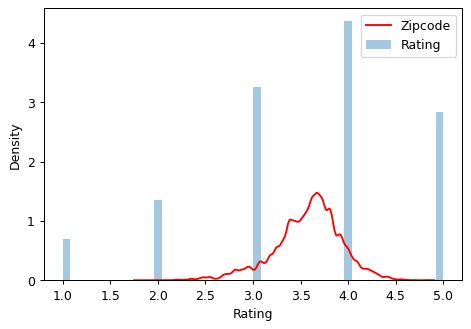

In [94]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train["Zip-code"], color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

The distribution of the encoded `Zipcode` feature roughly follows the distribution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode to zipcode that our target encoding was able to capture useful information.

If you would like to use KFold encoding, take a look at http://contrib.scikit-learn.org/category_encoders/wrapper.html#category_encoders.wrapper.NestedCVWrapper

## Data-centric AI with CleanLab

cleanlab automatically finds and fixes errors in any ML dataset. This data-centric AI package facilitates machine learning with messy, real-world data by providing clean labels during training.

You can checkout the tutorials at https://docs.cleanlab.ai/v2.0.0/tutorials/indepth_overview.html

## Exploratory Data Analysis

You can checkout some of useful EDA tools [pandas-profiling](https://github.com/ydataai/pandas-profiling), [dataprep](https://github.com/sfu-db/dataprep), [lux](https://github.com/lux-org/lux) or [pycaret](https://github.com/pycaret/pycaret)